Data: The dataset has future merchant transaction activity, for merchants that start over a 2 year period (2033-2034). The data spans from 1/1/33 through 12/31/34. Although the data is made up, you can consider this to be a random sample of future merchants using our payment processor. Each observation is a transaction amount in cents. If the merchant stops processing with our payment processor, then they would no longer appear.  

Questions:

1. We have limited data on these merchants and their transactions, but we are still interested in understanding their payments activity to try to infer the types of merchants using our payment processor. Using only the given data, how would you identify different kinds of businesses in the sample? Please generate assignments for each merchant.

2. Sometimes a merchant may stop processing with the payment processor, which we call churn. We are interested in identifying and predicting churn. Please a) come up with a concrete definition for churn b) identify merchants that have already churned in the dataset, and c) build a model to predict which active merchants are most likely to churn in the near future.

# Question 1 - Labeling Merchant Types

# Obtain Data

In [1]:
#import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import numpy as np
import datetime

In [2]:
#Read in the dataset and perform initial inspection
df = pd.read_csv('takehome_ds_written.csv')
df.head()

,Unnamed: 0,merchant,time,amount_usd_in_cents
0,1,faa029c6b0,6/17/2034 23:34,6349
1,2,ed7a7d91aa,12/27/2034 0:40,3854
2,3,5608f200cf,4/30/2034 1:29,789
3,4,15b1a0d61e,9/16/2034 1:06,4452
4,5,4770051790,7/22/2034 16:21,20203


# Scrub Data (null values, place holder values)

In [3]:
df.isnull().sum()

Unnamed: 0             0
merchant               0
time                   0
amount_usd_in_cents    0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   Unnamed: 0           1048575 non-null  int64 
 1   merchant             1048575 non-null  object
 2   time                 1048575 non-null  object
 3   amount_usd_in_cents  1048575 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 32.0+ MB


In [5]:
df.describe()

,Unnamed: 0,amount_usd_in_cents
count,1.048575e+06,1.048575e+06
mean,5.242880e+05,1.550347e+04
std,3.026977e+05,5.957772e+04
min,1.000000e+00,2.010000e+02
25%,2.621445e+05,3.221000e+03
50%,5.242880e+05,6.112000e+03
75%,7.864315e+05,1.262100e+04
max,1.048575e+06,1.640584e+07


In [6]:
#how many different merchants are we dealing with?
df.merchant.nunique()

13682

In [7]:
df['merchant'].value_counts()

5608f200cf    17692
53b3fbeae2     8453
1ddaea9838     8360
89e2d29885     8232
654930c922     7787
              ...  
8a16eb2d1e        1
0fa4b290f9        1
4b79f17a94        1
f23be3b729        1
1185d16b57        1
Name: merchant, Length: 13682, dtype: int64

In [8]:
#histogram of first merchant by usd_spent

In [9]:
#drop 'Unnamed: 0'
df.drop('Unnamed: 0', axis=1, inplace=True)

#rename amount_usd
df.rename(columns={'amount_usd_in_cents': 'amount_usd'}, inplace=True)

#divide amount_usd by 100 to convert into dollar amount
df['amount_usd'] = df['amount_usd']/100

# Initial Feature engineering

## Datetime object - create various time columns

In [10]:
#convert time column into a datetime object
df['time'] = df['time'].apply(pd.to_datetime)

In [11]:
#sort data frame by merchant and time
df = df.sort_values(by=['merchant', 'time'])

In [13]:
#create year, quarter, weekday_name, and hour columns
df['year'] = df['time'].dt.year
df['quarter'] = df['time'].dt.quarter
df['weekday_name'] = df['time'].dt.weekday
df['hour'] = df['time'].dt.hour
df['day'] = df['time'].dt.day
df['month'] = df['time'].dt.month

In [14]:
df.head()

,merchant,time,amount_usd,year,quarter,weekday_name,hour,day,month
438308,0002b63b92,2033-05-16 20:07:00,33.79,2033,2,0,20,16,5
835993,0002d07bba,2034-10-17 17:57:00,378.30,2034,4,1,17,17,10
891755,0002d07bba,2034-11-13 15:42:00,438.42,2034,4,0,15,13,11
874950,0002d07bba,2034-12-15 09:56:00,20.57,2034,4,4,9,15,12
883289,00057d4302,2033-05-30 01:30:00,12.48,2033,2,0,1,30,5


In [15]:
#create string columns for separate time frames
df['year_month_day'] = df['year'].astype(str) + '-' + df['month'].astype(str) + '-' + df['day'].astype(str)

df['year_month'] = df['year'].astype(str) + '-' + df['month'].astype(str)

df['year_quarter'] = df['year'].astype(str) + '-' + 'Q' + df['quarter'].astype(str)

## Column for Time Delta between transactions by Merchant

In [16]:
#make column to show that merchant's last transaction time
df['previous_time'] = df.groupby('merchant')['time'].shift(1)

In [17]:
#make a column to show time delta between the last purchase - show column in number of hours
df['td_last_purchase'] = ((df['time'] - df['previous_time']).dt.total_seconds())/3600

In [18]:
#replace null values in 'td_last_purchase' with zero
df['td_last_purchase'].fillna(0, inplace=True)

## Make various transaction count columns 

In [19]:
#create a column of a rolling count of total transactions for each merchant
df['tx_count'] = df.groupby('merchant').cumcount()+1

#count of transactions in a day for each merchant
df['tx_count_day'] = df.groupby(['merchant', 'year_month_day']).cumcount()+1

#count of transactions in a month for each merchant
df['tx_count_month'] = df.groupby(['merchant', 'year_month']).cumcount()+1

#count of transactions in a quarter for each merchant
df['tx_count_quarter'] = df.groupby(['merchant', 'year_quarter']).cumcount()+1

#count of transactions in a year for each merchant
df['tx_count_year'] = df.groupby(['merchant', 'year']).cumcount()+1

In [20]:
#check dataframe again
df.head()

,merchant,time,amount_usd,year,quarter,weekday_name,hour,day,month,year_month_day,year_month,year_quarter,previous_time,td_last_purchase,tx_count,tx_count_day,tx_count_month,tx_count_quarter,tx_count_year
438308,0002b63b92,2033-05-16 20:07:00,33.79,2033,2,0,20,16,5,2033-5-16,2033-5,2033-Q2,NaT,0.000000,1,1,1,1,1
835993,0002d07bba,2034-10-17 17:57:00,378.30,2034,4,1,17,17,10,2034-10-17,2034-10,2034-Q4,NaT,0.000000,1,1,1,1,1
891755,0002d07bba,2034-11-13 15:42:00,438.42,2034,4,0,15,13,11,2034-11-13,2034-11,2034-Q4,2034-10-17 17:57:00,645.750000,2,1,1,2,2
874950,0002d07bba,2034-12-15 09:56:00,20.57,2034,4,4,9,15,12,2034-12-15,2034-12,2034-Q4,2034-11-13 15:42:00,762.233333,3,1,1,3,3
883289,00057d4302,2033-05-30 01:30:00,12.48,2033,2,0,1,30,5,2033-5-30,2033-5,2033-Q2,NaT,0.000000,1,1,1,1,1


## Address merchants that transact less than 2 times in the dataset

In [21]:
#number of merchants that transacted one time
#should you consider these customers as a "churn"? - maybe it was a demo, or a trial
#no insight into spending habits for clusters
(df.groupby('merchant')['tx_count'].max() < 2).sum()

1923

In [22]:
#% of unique merchants that transacted one time
(df.groupby('merchant')['tx_count'].max() < 2).sum()/(df.merchant.nunique())

0.14054962724747844

Very interesting to note that about 14% of merchants have only transacted one time in this dataset. Probably makes sense to drop them from the data considering we don't have enough data points on them to group them into a "merchant type" cluster or to define their churn.

In [23]:
#make a list of all the merchants that transacted less than 2 times and take them from the dataset
low_tx = df.groupby('merchant')['tx_count'].max()[lambda x: x < 2].reset_index()
list_low_tx = list(low_tx['merchant'])

In [24]:
len(list_low_tx)

1923

In [25]:
#drop the merchants that transacted less than 2 times in the dataframe
df = df[~df['merchant'].isin(list_low_tx)]

# EDA - Exploratory Data Analysis

## When are Merchants transacting? 

In [26]:
def total_and_count(x, y):
    ###Function to show visual for various time features on the x-axis vs the Total USD spend on the y-axis
    ###second visual shows various time features on x-axis vs the Count of Transactions on the y-axis
    
    #create groupby objects of X variable to calculate the sum and count of the y-variable 
    sum_groupby_object = df.groupby(x)[y].sum().reset_index()
    count_groupby_object = df.groupby(x)[y].count().reset_index()

    #create subplots for two graphs
    figure = plt.figure(figsize=(15,10))
    ax = figure.add_subplot(121)
    ax2 = figure.add_subplot(122)

    #first graph shows Total USD Spend vs time features
    sns.barplot(x=sum_groupby_object[x], y=sum_groupby_object[y], ax=ax)
    ax.set_title('Total USD Spend per {}'.format(x))
    ax.ticklabel_format(style='plain', axis='y',useOffset=False)
    ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

    #Second graph shows Count of Transactions vs time features
    sns.barplot(x=count_groupby_object[x], y=count_groupby_object[y], ax=ax2)
    ax2.set_title('Count of Transactions per {}'.format(x))
    ax2.ticklabel_format(style='plain', axis='y',useOffset=False)
    ax2.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

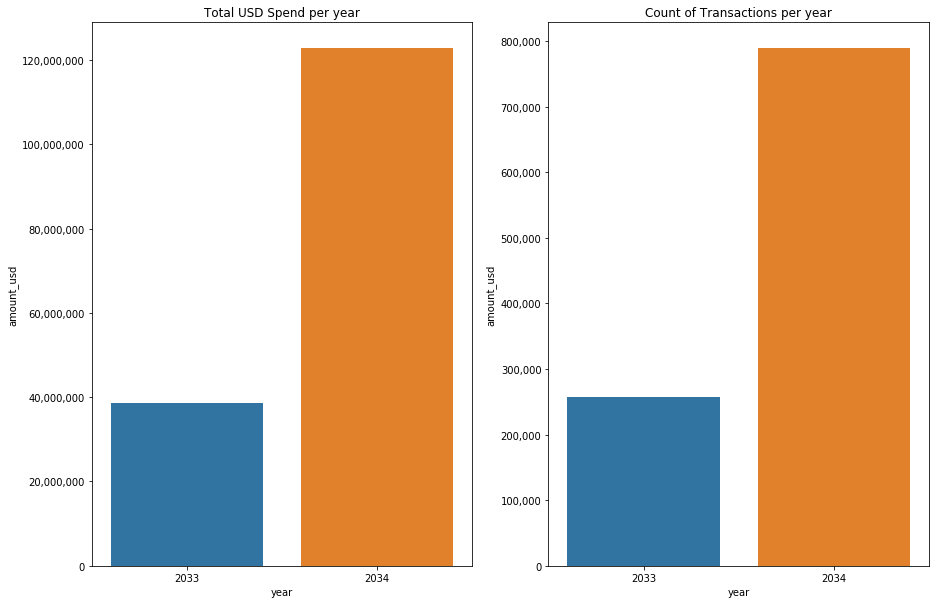

In [27]:
total_and_count('year', 'amount_usd')

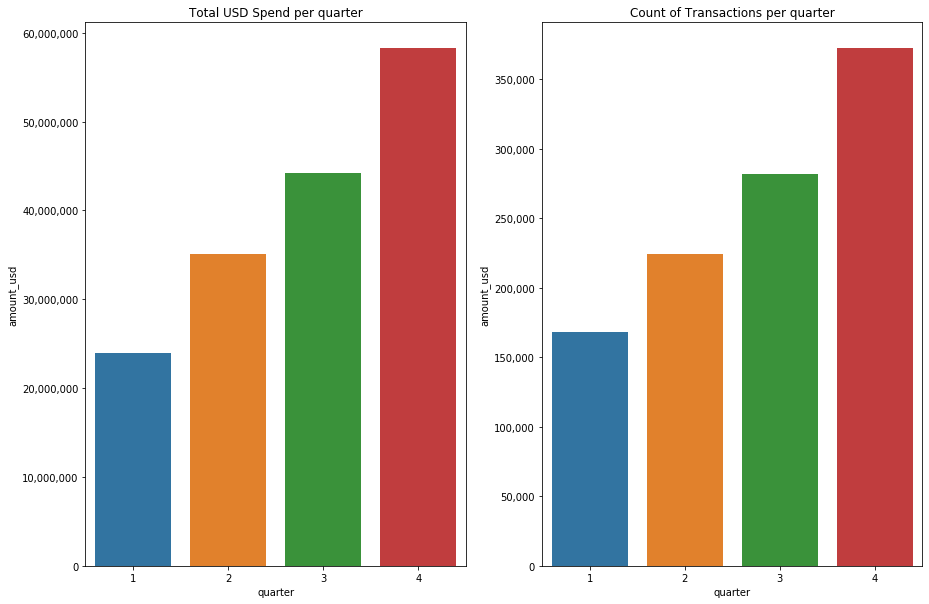

In [28]:
total_and_count('quarter', 'amount_usd')

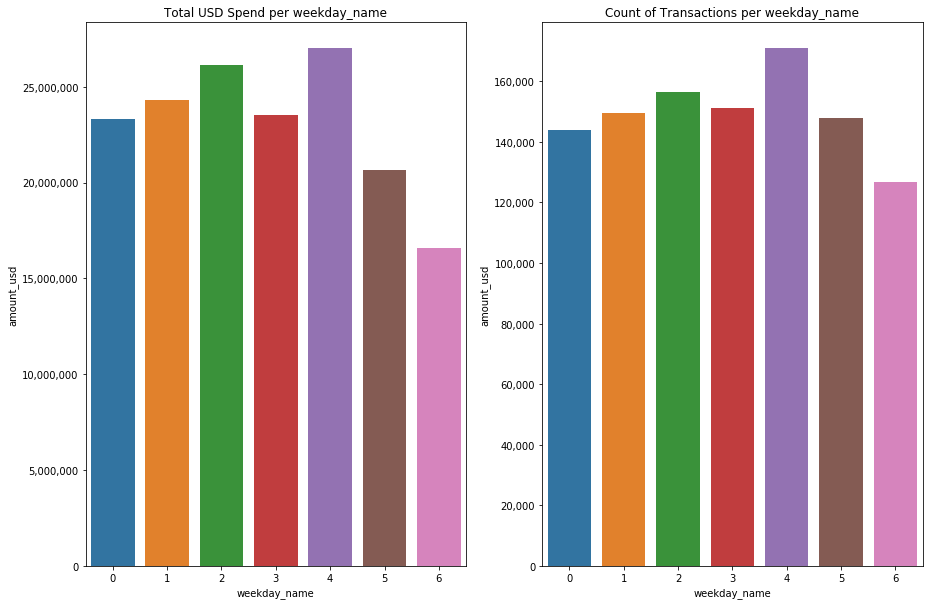

In [29]:
total_and_count('weekday_name', 'amount_usd')

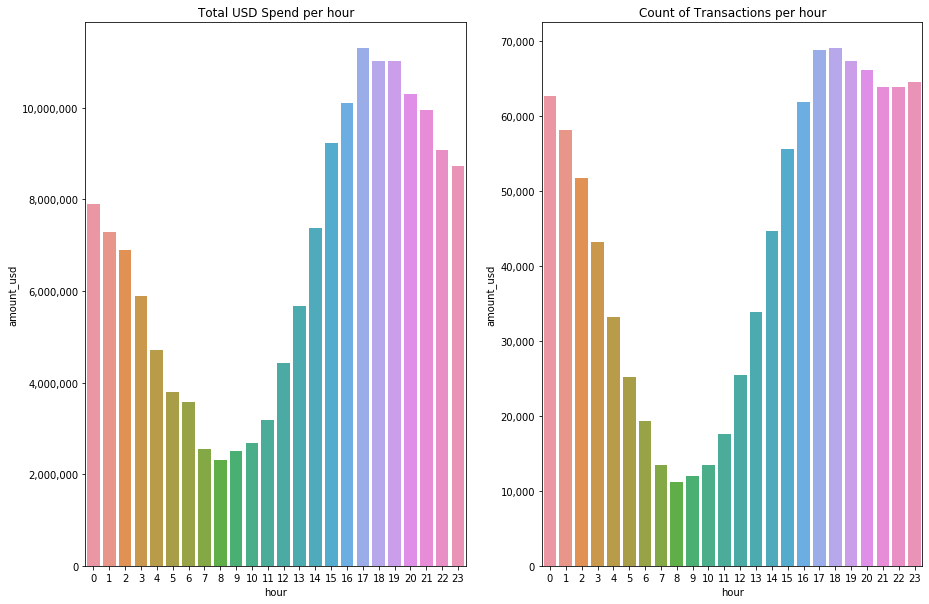

In [30]:
total_and_count('hour', 'amount_usd')

Looks like merchants are moer active for hours 0, 1, 2 and 15 through 23 (12 hour period)
Less active(below 50k transactions) for hours 3 through 14 (12 hour period)

Could also break it up by three groups
transactions 20k and under: hours 6, 7, 8, 9, 10, 11
35k and 45k: hours 3, 4, 5 and 12, 13, 14
15 through 23 and 0, 1, 2 (12 hours)

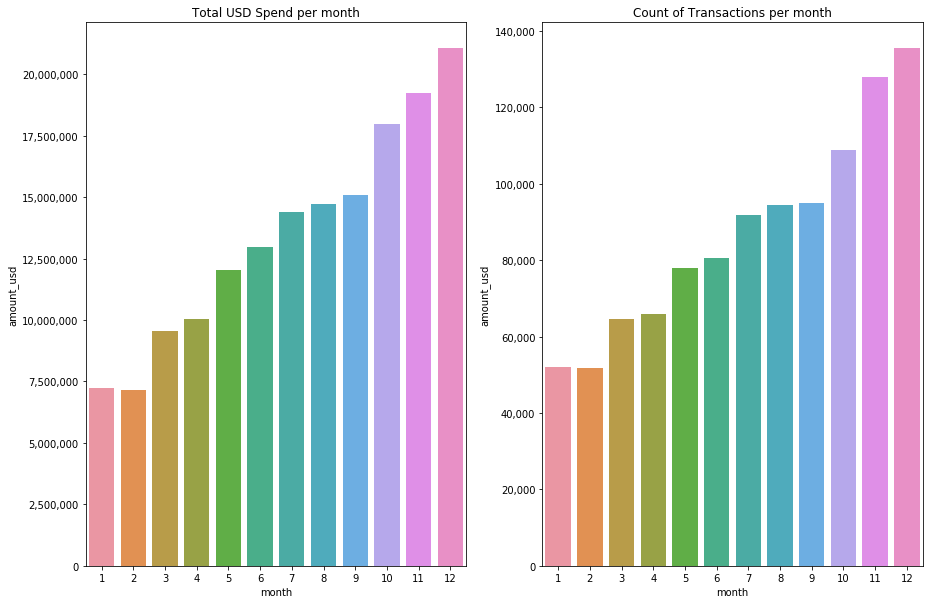

In [31]:
total_and_count('month', 'amount_usd')

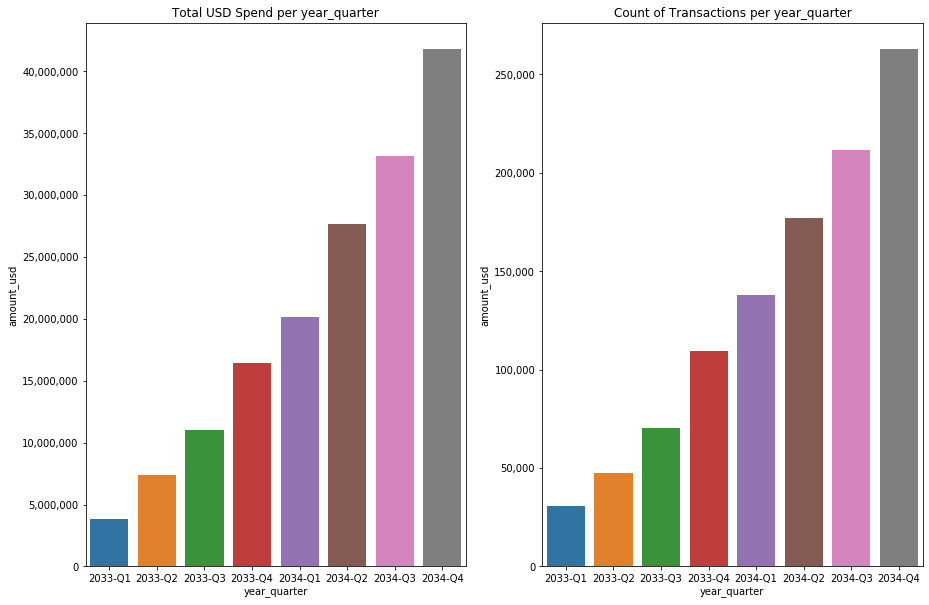

In [32]:
total_and_count('year_quarter', 'amount_usd')

## Dealing with Categorical variables

In [33]:
#create column for weekday vs weekend instead of weekday_name 
#0 = weekend, 1 = weekday

df['weekday'] = df['weekday_name'].apply(lambda x: 0 if (x==5 or x==6) else 1)

In [34]:
#create column to split hours into two groups: 'active' is hours 0-2 and 15-23 and 'less active' is hours 3-14
df['active_hours'] = df['hour'].apply(lambda x: 0 if (x >= 3 and x <= 14) else 1)

In [35]:
#create one-hot encoded year column
df['year_2033'] = df['year'].apply(lambda x: 0 if (x == 2034) else 1) 

In [36]:
#one-hot encode categorical variables, drop first column because it will be redundant data
one_hot = pd.get_dummies(df['quarter'], prefix='quarter', drop_first=True)

#convert one_hot to int64
one_hot = one_hot.astype('int64')

#check it out
one_hot.head()

,quarter_2,quarter_3,quarter_4
835993,0,0,1
891755,0,0,1
874950,0,0,1
883289,1,0,0
40102,1,0,0


In [37]:
#join one_hot with df
df = df.join(one_hot)

In [38]:
#drop unnecessary columns
df.drop(['weekday_name', 'hour', 'year', 'quarter', 'day', 'month','previous_time'], axis=1, inplace=True)

## Average Spend and Average time Delta per Merchant

In [42]:
#average amount_usd and average time between transactions per merchant
df.groupby('merchant')[['amount_usd', 'td_last_purchase']].mean().reset_index().describe()

,amount_usd,td_last_purchase
count,11759.000000,11759.000000
mean,331.553244,432.011901
std,1196.819287,654.252827
min,2.180000,0.006348
25%,56.635439,53.505093
50%,103.213333,188.641781
75%,245.116535,528.526190
max,89585.768000,8696.358333


Text(0, 0.5, 'Average Amount Spent')

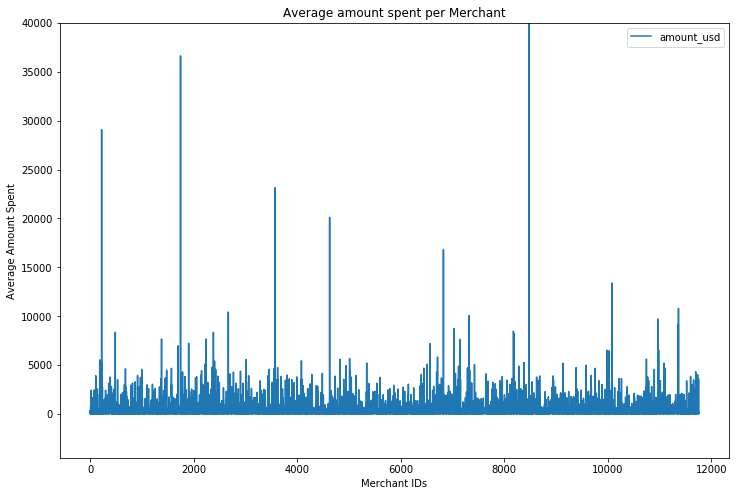

In [39]:
df.groupby('merchant')['amount_usd'].mean().reset_index().plot(figsize=(12,8))
plt.ylim(top=40000)
plt.title('Average amount spent per Merchant')
plt.xlabel('Merchant IDs')
plt.ylabel('Average Amount Spent')

Text(0, 0.5, 'Average Time Delta (in days)')

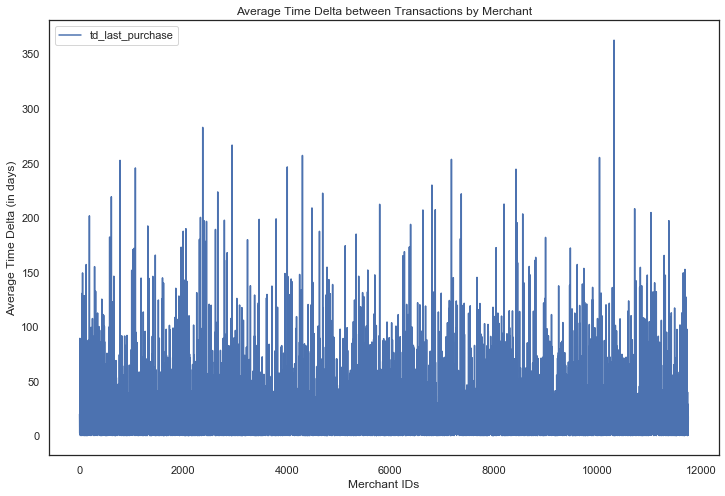

In [136]:
(df.groupby('merchant')['td_last_purchase'].mean()/24).reset_index().plot(figsize=(12,8))
plt.title('Average Time Delta between Transactions by Merchant')
plt.xlabel('Merchant IDs')
plt.ylabel('Average Time Delta (in days)')

## Transaction Frequency per Merchant

In [140]:
#max transactions in a day, max transactions in a month, max transactions lifetime per merchant
df.groupby('merchant')[['tx_count_day', 'tx_count_month', 'tx_count_quarter', 'tx_count']].max().reset_index().describe()

,tx_count_day,tx_count_month,tx_count_quarter,tx_count
count,11759.000000,11759.000000,11759.000000,11759.000000
mean,8.421634,23.414831,39.650566,89.008589
std,76.941806,117.324706,174.992753,402.128588
min,1.000000,1.000000,1.000000,2.000000
25%,1.000000,2.000000,3.000000,4.000000
50%,2.000000,5.000000,7.000000,12.000000
75%,4.000000,15.000000,24.000000,44.000000
max,6221.000000,7644.000000,7648.000000,17692.000000


Text(0, 0.5, 'Transaction Count')

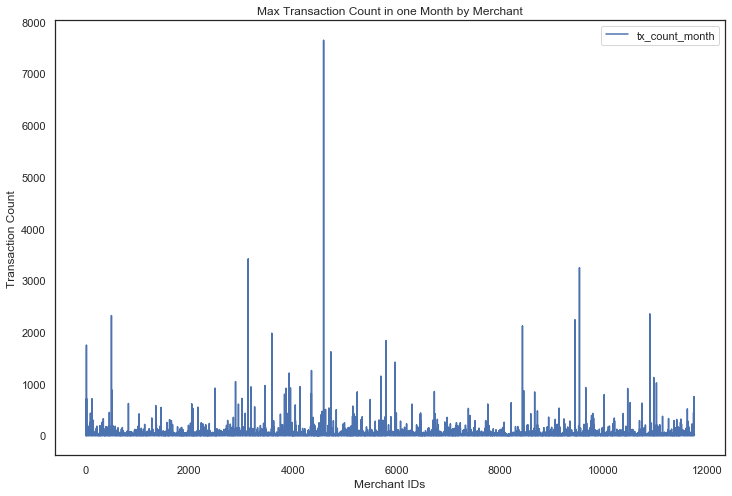

In [139]:
df.groupby('merchant')[['tx_count_month']].max().reset_index().plot(figsize=(12,8))
plt.title('Max Transaction Count in one Month by Merchant')
plt.xlabel('Merchant IDs')
plt.ylabel('Transaction Count')

## Transaction counts across different time periods

In [43]:
#total count of transactions in quarters, active_hours, weekday, and year per merchant
df.groupby('merchant')[['quarter_2', 'quarter_3', 'quarter_4', 
                        'active_hours', 'weekday', 'year_2033']].sum().reset_index().describe()

,quarter_2,quarter_3,quarter_4,active_hours,weekday,year_2033
count,11759.000000,11759.000000,11759.000000,11759.000000,11759.000000,11759.000000
mean,19.088103,23.939961,31.665788,64.127392,65.651331,21.898716
std,105.742042,114.081443,156.239823,290.776734,300.542563,159.652706
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,3.000000,3.000000,0.000000
50%,1.000000,2.000000,3.000000,8.000000,9.000000,0.000000
75%,7.000000,10.000000,14.000000,30.000000,33.000000,6.000000
max,4405.000000,5090.000000,6417.000000,11838.000000,12623.000000,7649.000000


## Build a dataframe with aggregated merchant data for a clustering model

In [44]:
#look at the average amount_usd and average time delta across merchants
#this gives you an idea of the average spend and average frequency of transacting for each merchant
mean_amount = df.groupby('merchant')[['amount_usd', 'td_last_purchase']].mean().reset_index()

#look at the maximum transaction count per day and per month across merchants
#this gives you an idea of how frequently each merchant transacts each day and each month
max_tx_count = df.groupby('merchant')[['tx_count_day', 'tx_count_month']].max().reset_index()

#look at the sum of transaction counts in quarter_2, quarter_3, quarter_4, active_hours, weekday, year_2033 across merchants
#this will give you an idea of how active each merchant is in different time frames
sum_time = df.groupby('merchant')[['quarter_2', 'quarter_3', 'quarter_4', 'active_hours', 'weekday', 'year_2033']].sum().reset_index()

In [45]:
#create one dataframe that has all of the aggregated features from above
merged_grouped_df = mean_amount.merge(max_tx_count, on='merchant').merge(sum_time, on='merchant')

In [46]:
merged_grouped_df.head()

,merchant,amount_usd,td_last_purchase,tx_count_day,tx_count_month,quarter_2,quarter_3,quarter_4,active_hours,weekday,year_2033
0,0002d07bba,279.096667,469.327778,1,1,0,0,3,2,3,0
1,00057d4302,8.336875,99.167708,9,9,9,7,0,10,16,16
2,000ed1585f,265.960476,374.867857,2,4,14,13,6,29,34,25
3,000f8c3297,113.812212,51.001122,5,26,50,54,81,91,205,8
4,0026f256ac,354.706000,424.463333,1,2,1,4,0,3,3,5


In [47]:
merged_grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11759 entries, 0 to 11758
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   merchant          11759 non-null  object 
 1   amount_usd        11759 non-null  float64
 2   td_last_purchase  11759 non-null  float64
 3   tx_count_day      11759 non-null  int64  
 4   tx_count_month    11759 non-null  int64  
 5   quarter_2         11759 non-null  int64  
 6   quarter_3         11759 non-null  int64  
 7   quarter_4         11759 non-null  int64  
 8   active_hours      11759 non-null  int64  
 9   weekday           11759 non-null  int64  
 10  year_2033         11759 non-null  int64  
dtypes: float64(2), int64(8), object(1)
memory usage: 1.1+ MB


In [48]:
merged_grouped_df.describe()

,amount_usd,td_last_purchase,tx_count_day,tx_count_month,quarter_2,quarter_3,quarter_4,active_hours,weekday,year_2033
count,11759.000000,11759.000000,11759.000000,11759.000000,11759.000000,11759.000000,11759.000000,11759.000000,11759.000000,11759.000000
mean,331.553244,432.011901,8.421634,23.414831,19.088103,23.939961,31.665788,64.127392,65.651331,21.898716
std,1196.819287,654.252827,76.941806,117.324706,105.742042,114.081443,156.239823,290.776734,300.542563,159.652706
min,2.180000,0.006348,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,56.635439,53.505093,1.000000,2.000000,0.000000,0.000000,0.000000,3.000000,3.000000,0.000000
50%,103.213333,188.641781,2.000000,5.000000,1.000000,2.000000,3.000000,8.000000,9.000000,0.000000
75%,245.116535,528.526190,4.000000,15.000000,7.000000,10.000000,14.000000,30.000000,33.000000,6.000000
max,89585.768000,8696.358333,6221.000000,7644.000000,4405.000000,5090.000000,6417.000000,11838.000000,12623.000000,7649.000000


# Final feature selection for model

In [49]:
#select features for k-means algo - use everything from amount_usd_in_cents to avg_time_diff_minutes
X = merged_grouped_df.iloc[:, 1:]

In [50]:
X.head()

,amount_usd,td_last_purchase,tx_count_day,tx_count_month,quarter_2,quarter_3,quarter_4,active_hours,weekday,year_2033
0,279.096667,469.327778,1,1,0,0,3,2,3,0
1,8.336875,99.167708,9,9,9,7,0,10,16,16
2,265.960476,374.867857,2,4,14,13,6,29,34,25
3,113.812212,51.001122,5,26,50,54,81,91,205,8
4,354.706000,424.463333,1,2,1,4,0,3,3,5


# Feature Scaling

In [51]:
#try MinMaxScaler first
#MinMaxScaler makes every value between 0 and 1 
#standardscaler makes mean=0, and sd=1
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

min_max = MinMaxScaler().fit_transform(X)
#standard_scaler = StandardScaler().fit_transform(X)

In [52]:
cols = X.columns
X = pd.DataFrame(data=min_max, columns=[cols])

In [53]:
X.head()

,amount_usd,td_last_purchase,tx_count_day,tx_count_month,quarter_2,quarter_3,quarter_4,active_hours,weekday,year_2033
0,0.003091,0.053968,0.000000,0.000000,0.000000,0.000000,0.000468,0.000169,0.000238,0.000000
1,0.000069,0.011403,0.001286,0.001047,0.002043,0.001375,0.000000,0.000845,0.001268,0.002092
2,0.002945,0.043106,0.000161,0.000393,0.003178,0.002554,0.000935,0.002450,0.002693,0.003268
3,0.001246,0.005864,0.000643,0.003271,0.011351,0.010609,0.012623,0.007687,0.016240,0.001046
4,0.003935,0.048809,0.000000,0.000131,0.000227,0.000786,0.000000,0.000253,0.000238,0.000654


# Modeling - K-means clustering algo

## It makes the most sense to use an unsupervised learning model such as K-means clustering since we are dealing with unlabeled data here in terms of merchant type

In [54]:
from sklearn.cluster import KMeans

#create a KMeans object and set n_clusters = 3 to start off
k_means = KMeans(n_clusters=3)

#first the k_means object to the data stored in X
k_means.fit(X)

#generate cluster predictions with k_means and store the result in the dataframe
merged_grouped_df['merchant_type'] = k_means.predict(X)

In [55]:
merged_grouped_df.merchant_type.value_counts()

0    10515
1     1169
2       75
Name: merchant_type, dtype: int64

In [56]:
k_means.inertia_

49.69884788417113

In [57]:
merged_grouped_df.groupby('merchant_type').mean()

,amount_usd,td_last_purchase,tx_count_day,tx_count_month,quarter_2,quarter_3,quarter_4,active_hours,weekday,year_2033
merchant_type,,,,,,,,,,
0,308.035051,259.494991,7.358821,20.090823,15.069520,19.316976,26.134760,51.315739,52.417879,15.846125
1,558.534146,2011.248251,1.157399,1.690334,1.064157,1.152267,1.581694,3.245509,3.612489,1.750214
2,90.928137,3.852025,270.653333,828.053333,863.426667,1027.266667,1276.026667,2809.266667,2887.960000,1184.520000


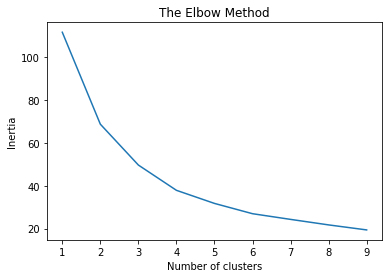

In [58]:
#use elbow method to find optimal number of clusters
inertia = []
for i in range(1, 10):
    k_means = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    k_means.fit(X)
    inertia.append(k_means.inertia_)
#plt.figure(figsize=(15,10))
plt.plot(range(1, 10), inertia)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

seems like there is an elbow at n_clusters = 4, but it isn't super clear from this graph. Could do 5 or 6 clusters 

try n_clusters = 4

In [59]:
merged_grouped_df.drop('merchant_type', axis=1, inplace=True)

In [60]:
#create a KMeans object
k_means = KMeans(n_clusters=4)

#first the k_means object to the data stored in X
k_means.fit(X)

#generate cluster predictions with k_means and store the result in the dataframe
merged_grouped_df['merchant_type'] = k_means.predict(X)

In [143]:
merged_grouped_df.merchant_type.value_counts()

Ecommerce    9097
SaaS         2134
B2B           464
B2C            64
Name: merchant_type, dtype: int64

# Interpretation of Results

In [153]:
#look at the average statistics across labeled merchant_types
merged_grouped_df.groupby('merchant_type').mean()

,amount_usd,td_last_purchase,tx_count_day,tx_count_month,quarter_2,quarter_3,quarter_4,active_hours,weekday,year_2033
merchant_type,,,,,,,,,,
B2B,559.148784,2854.583082,1.073276,1.375000,0.752155,0.855603,1.297414,2.487069,2.663793,1.568966
B2C,93.254206,3.494210,308.984375,906.328125,945.656250,1106.234375,1363.968750,3034.156250,3113.296875,1292.250000
Ecommerce,269.705615,170.691504,8.328460,23.226338,17.577663,22.669342,30.688029,60.213807,61.459492,18.549412
SaaS,552.862843,1032.098008,1.402530,2.531396,1.725398,1.917057,2.480319,5.140112,5.815370,2.498126


## Conclusion:

In [64]:
#rename merchant types
merged_grouped_df['merchant_type'].replace({0: 'Ecommerce', 1: 'B2B', 2: 'SaaS', 3: 'B2C'}, inplace=True)

In [65]:
def cluster_plots(y):
    ###Function to look at the merchant type clusters on the x-axis vs the averages of various features on the y-axis
    
    #barplot
    ax = sns.barplot(x=merged_grouped_df['merchant_type'], y=merged_grouped_df[y])
    ax.set_title('Average {}'.format(y))
    ax.ticklabel_format(style='plain', axis='y',useOffset=False)
    ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

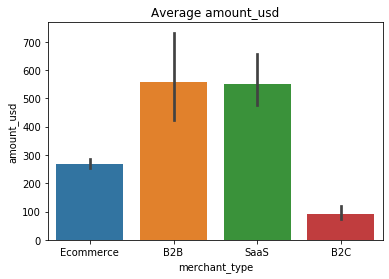

In [66]:
cluster_plots('amount_usd')

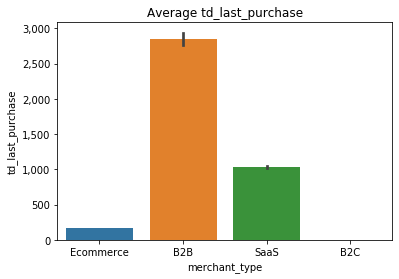

In [67]:
cluster_plots('td_last_purchase')

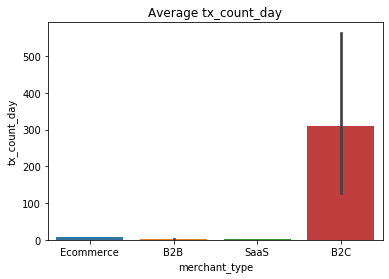

In [68]:
cluster_plots('tx_count_day')

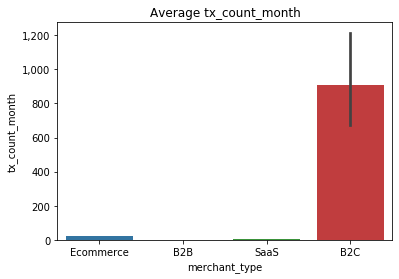

In [69]:
cluster_plots('tx_count_month')

In [142]:
#show seasonality
merged_grouped_df.groupby('merchant_type')['quarter_2', 'quarter_3', 'quarter_4'].mean()

C:\Users\Thomas\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,quarter_2,quarter_3,quarter_4
merchant_type,,,
B2B,0.752155,0.855603,1.297414
B2C,945.656250,1106.234375,1363.968750
Ecommerce,17.577663,22.669342,30.688029
SaaS,1.725398,1.917057,2.480319


Based on the average features by each merchant type:

clusters 0: Ecommerce/Retail: relatively frequent medium sized transactions, more seasonality: Amazon, Target

cluster 1: B2B: pays monthly/bimonthly/quarterly in largest amounts: Salesforce, Shopify

cluster 2: SaaS: Pays biweekly/monthly in larger amounts: Docusign, Tableau, Splunk

cluster 3: B2C: frequent small transactions: Lyft, Doordash

In [62]:
k_means.inertia_

37.865302120139454

Inertia = 37.86: sum of squared error for each cluster. The smaller the inertia the denser the cluster. Too far from zero

Features - Average spend, time delta, and transaction count features have significant variance across clusters as shown above

Curse of dimensionality – too many features for k-means

With more time I would try to tune my model to get the inertia closer to zero so I could have tighter clusters.

# Question 2 - Churn

Sometimes a merchant may stop transacting with the payment processor, which we call churn. We are interested in identifying and predicting churn. Please a) come up with a concrete definition for churn b) identify merchants that have already churned in the dataset, and c) build a model to predict which active merchants are most likely to churn in the near future.

## Question 2a: Concrete definition for churn

### My initial thought is that each merchant type has different customers so the churn would be defined differently for each merchant type.

In [144]:
#look at the average time delta between transactions for each merchant group in days:
((merged_grouped_df.groupby('merchant_type')['td_last_purchase'].mean())/24).reset_index()

,merchant_type,td_last_purchase
0,B2B,118.940962
1,B2C,0.145592
2,Ecommerce,7.112146
3,SaaS,43.004084


In [72]:
#look at the average time delta in days between purchases across each merchant 
((df.groupby('merchant')['td_last_purchase'].mean())/24).mean()

18.000495869466633

18 days is the average time delta between purchases across all merchants in the dataset. This average can be misleading given Ecommerce and B2C merchant types have a time delta average of a week or less.

Text(0, 0.5, 'Frequency')

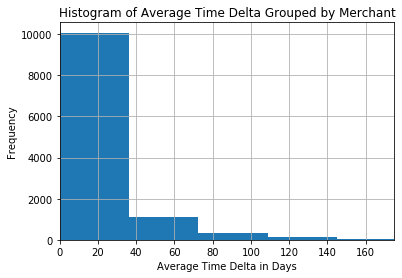

In [73]:
#check the distribution of average time delta 
((df.groupby('merchant')['td_last_purchase'].mean())/24).hist()
plt.xlim(0, 175)
plt.title('Histogram of Average Time Delta Grouped by Merchant')
plt.xlabel('Average Time Delta in Days')
plt.ylabel('Frequency')

In [74]:
#What percent of merchants have an average time delta of 90 days or less?
(((df.groupby('merchant')['td_last_purchase'].mean())/24)<90).sum()/(df['merchant'].nunique())

0.96955523428863

About 97% of merchants have an average time delta between transactions of 90 days or less. 

### Using the distribution of average time delta between transactions for each merchant as a guide to define my churn I think one quarter (90 days) of inactivity looks like an OK definition across all merchant types. 

### If I had more time I would have a different definition of churn for each merchant type and look at churn across each merchant type separately. 

## Question 2b: Identify which merchants have already churned

In [75]:
#column that gives you the next transaction time for that merchant
df['future_date'] = df.groupby('merchant')['time'].shift(-1)

In [76]:
#create a churn column based on if that merchant had a transaction within 90 days or not
df['churn'] = np.where((((df['future_date'] - df['time']).dt.days) > 90) | (df['future_date'].isnull()), 1, 0)

In [77]:
df.churn.value_counts()

0    1030576
1      16076
Name: churn, dtype: int64

In [78]:
#make any transactions that happened on the last day before a churn, a churn 
#this will give us a more balanced dataset
df['churn_transform'] = df.groupby(['merchant', 'year_month_day'])['churn'].transform(max)

In [89]:
df.churn_transform.value_counts()

0    1019692
1      26960
Name: churn_transform, dtype: int64

### Dataframe without Q4 2034:

In [79]:
#create a dataframe that excludes the dates from Q4-2034 since we can't determine if they are a churn or not
#this will also be the training data for the prediction model
df_nolastq = df[df['year_quarter'] != '2034-Q4']

In [80]:
#testing data for the model will be just Q4-2034
df_lastq = df[df['year_quarter'] == '2034-Q4']

### List of merchants that have already churned

In [81]:
#list of unique merchants that have already churned
list(df_nolastq[df_nolastq['churn'] == 1]['merchant'].unique())

['00057d4302',
 '000ed1585f',
 '0026f256ac',
 '0037a192b4',
 '0042aadfdf',
 '0047f556b5',
 '004a994585',
 '004d02cb10',
 '005c218139',
 '0063ff0c6b',
 '007364b02a',
 '0082de98e9',
 '0084eddcc7',
 '0085991c76',
 '0097b9f523',
 '00ab614386',
 '00ae6015d0',
 '00bf6e541e',
 '00c1ce3556',
 '00cd72cf0e',
 '00e7748c5b',
 '00ffc7c38b',
 '010749c732',
 '0111d7d609',
 '01229befeb',
 '0125d43ba4',
 '013cc2cd06',
 '01422c116f',
 '0147289ac5',
 '0149d4bfba',
 '014de96817',
 '0150c59efd',
 '0153aebab1',
 '0155692eb6',
 '015f6dc983',
 '017130662b',
 '01714118fa',
 '01741912b7',
 '0179c7a02d',
 '018484a73d',
 '01874bc7cf',
 '0194c4e788',
 '01c89d040b',
 '01d7aab444',
 '01e75670d6',
 '01f6668962',
 '020822e431',
 '020fc8300d',
 '02195f8d1a',
 '0221954dfe',
 '0221b4736b',
 '023f542244',
 '024eba0e34',
 '0252834ede',
 '02573c50ed',
 '025e237cf5',
 '0276515bcb',
 '02794a5ea5',
 '028d01b0c5',
 '0290e4ad90',
 '0294660a13',
 '029a0ed7d7',
 '029b8d26b9',
 '02a42d9d45',
 '02ac035459',
 '02b37cb5bf',
 '02bb6bfb

In [82]:
#list of merchants that churned (also includes duplicate merchants when they churn more than once)
list(df_nolastq[df_nolastq['churn'] == 1]['merchant'])

['00057d4302',
 '000ed1585f',
 '0026f256ac',
 '0037a192b4',
 '0037a192b4',
 '0042aadfdf',
 '0047f556b5',
 '004a994585',
 '004d02cb10',
 '005c218139',
 '0063ff0c6b',
 '0063ff0c6b',
 '007364b02a',
 '007364b02a',
 '007364b02a',
 '0082de98e9',
 '0084eddcc7',
 '0085991c76',
 '0097b9f523',
 '00ab614386',
 '00ae6015d0',
 '00bf6e541e',
 '00bf6e541e',
 '00bf6e541e',
 '00c1ce3556',
 '00cd72cf0e',
 '00cd72cf0e',
 '00cd72cf0e',
 '00e7748c5b',
 '00ffc7c38b',
 '010749c732',
 '0111d7d609',
 '0111d7d609',
 '0111d7d609',
 '01229befeb',
 '0125d43ba4',
 '013cc2cd06',
 '01422c116f',
 '0147289ac5',
 '0147289ac5',
 '0149d4bfba',
 '014de96817',
 '014de96817',
 '0150c59efd',
 '0150c59efd',
 '0150c59efd',
 '0153aebab1',
 '0153aebab1',
 '0155692eb6',
 '0155692eb6',
 '015f6dc983',
 '015f6dc983',
 '017130662b',
 '01714118fa',
 '01741912b7',
 '0179c7a02d',
 '0179c7a02d',
 '018484a73d',
 '018484a73d',
 '01874bc7cf',
 '0194c4e788',
 '01c89d040b',
 '01d7aab444',
 '01d7aab444',
 '01e75670d6',
 '01f6668962',
 '020822e4

## Question 2c: Make a model to predict churn 

In [148]:
# What % Churned?
df_nolastq.churn_transform.value_counts(normalize=True)

0    0.978714
1    0.021286
Name: churn_transform, dtype: float64

heavily skewed towards most rows not being a churn which makes modeling more difficult

In [84]:
#how many unique merchants in the dataframe without Q4 2034
df_nolastq['merchant'].nunique()

10305

In [145]:
#number of unique merchants that churned at least once
df_nolastq[df_nolastq['churn'] == 1]['merchant'].nunique()

6739

In [85]:
#percent of unique merchants that churned at least once
df_nolastq[df_nolastq['churn'] == 1]['merchant'].nunique()/(df_nolastq['merchant'].nunique())

0.653954391072295

In [86]:
#what percent of merchants churned more than once?
((df_nolastq[df_nolastq['churn'] == 1]['merchant'].value_counts()>1).sum())/(df_nolastq['merchant'].nunique())

0.17049975739932072

Interesting to note that there is a high % of churn when you look at things by unique merchant but not when you look at each row of the dataframe.

In [87]:
df_nolastq.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 783572 entries, 883289 to 506636
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   merchant          783572 non-null  object        
 1   time              783572 non-null  datetime64[ns]
 2   amount_usd        783572 non-null  float64       
 3   year_month_day    783572 non-null  object        
 4   year_month        783572 non-null  object        
 5   year_quarter      783572 non-null  object        
 6   td_last_purchase  783572 non-null  float64       
 7   tx_count          783572 non-null  int64         
 8   tx_count_day      783572 non-null  int64         
 9   tx_count_month    783572 non-null  int64         
 10  tx_count_quarter  783572 non-null  int64         
 11  tx_count_year     783572 non-null  int64         
 12  weekday           783572 non-null  int64         
 13  active_hours      783572 non-null  int64         
 14 

In [88]:
#get an idea of which features influence churn vs no churn
df_nolastq.groupby('churn').mean()

,amount_usd,td_last_purchase,tx_count,tx_count_day,tx_count_month,tx_count_quarter,tx_count_year,weekday,active_hours,year_2033,quarter_2,quarter_3,quarter_4,churn_transform
churn,,,,,,,,,,,,,,
0,150.030904,51.238735,873.517954,44.301488,143.138516,276.036004,583.591377,0.744648,0.717564,0.327640,0.286296,0.359470,0.139289,0.010141
1,385.016610,740.381625,22.332918,1.890614,6.051689,10.253457,16.642938,0.763999,0.703242,0.415779,0.300272,0.341306,0.154613,1.000000


right away its pretty interesting that time delta since last purchase seems to be a huge differentiator. transaction count variables also seem to be pretty important. When the transactions happen seem to be less important here vs the clustering.

### EDA 

In [90]:
def churn_plots(y):
    ###Function to visualize Churn (target variable) vs potential features
    ### first visual is barplot showing average of churn group vs non-churn group
    ### second visual is violinplot showing the average of churn group vs non-churn group
    
    #create subplots for two visuals
    figure = plt.figure(figsize=(12,8))
    ax = figure.add_subplot(121)
    ax2 = figure.add_subplot(122)

    #barplot
    sns.barplot(x=df_nolastq['churn'], y=df_nolastq[y], ax=ax)
    ax.set_title('Average {}'.format(y))
    ax.ticklabel_format(style='plain', axis='y',useOffset=False)
    ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

    #violinplot
    sns.violinplot(x=df_nolastq['churn'], y=df_nolastq[y], ax=ax2)
    ax2.set_title('Average {}'.format(y))
    ax2.ticklabel_format(style='plain', axis='y',useOffset=False)
    ax2.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

In [91]:
feature_list = ['amount_usd', 'td_last_purchase', 'tx_count', 'tx_count_day', 
                'tx_count_month','tx_count_quarter', 'tx_count_year','weekday', 
                'active_hours', 'year_2033', 'quarter_2', 'quarter_3', 'quarter_4']

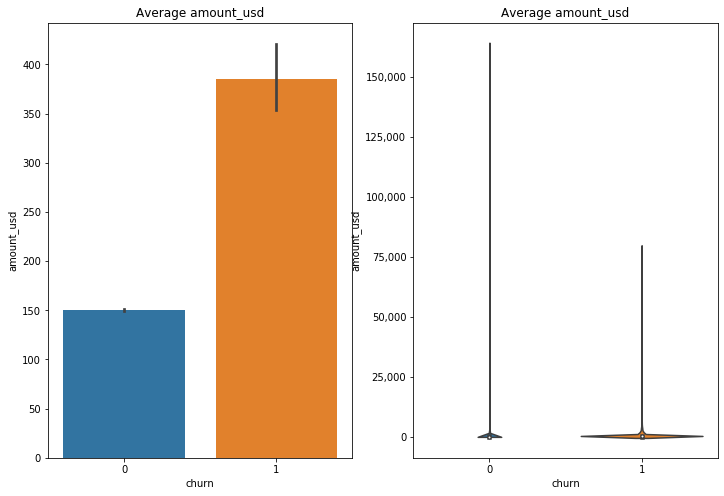

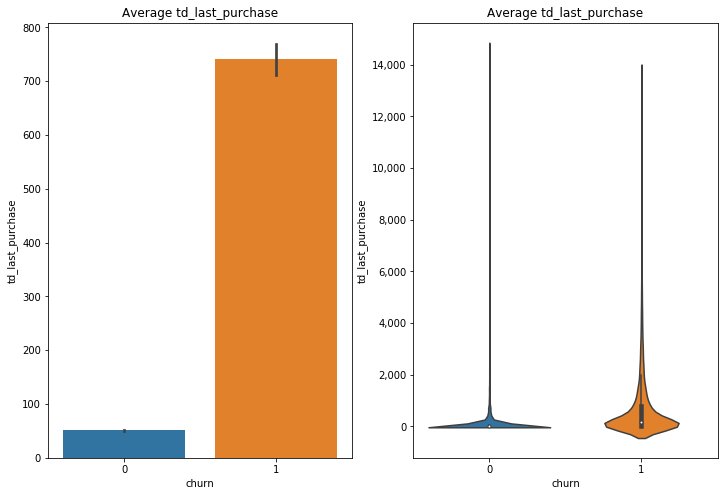

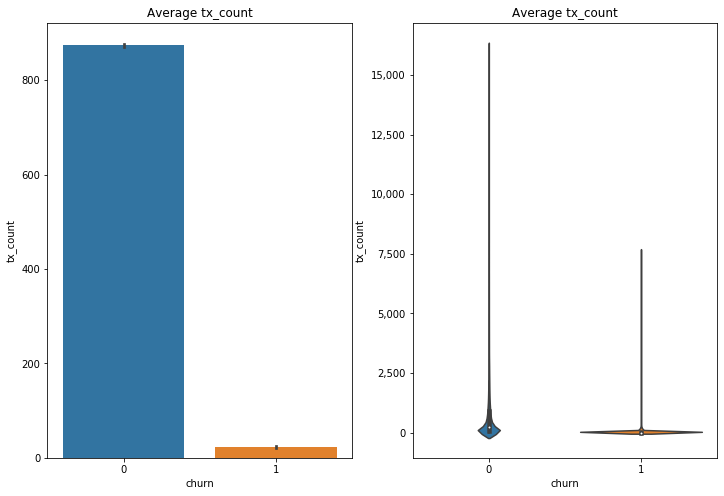

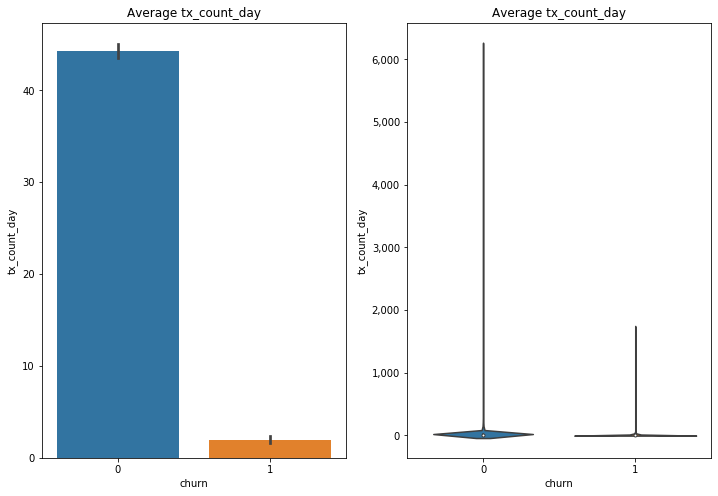

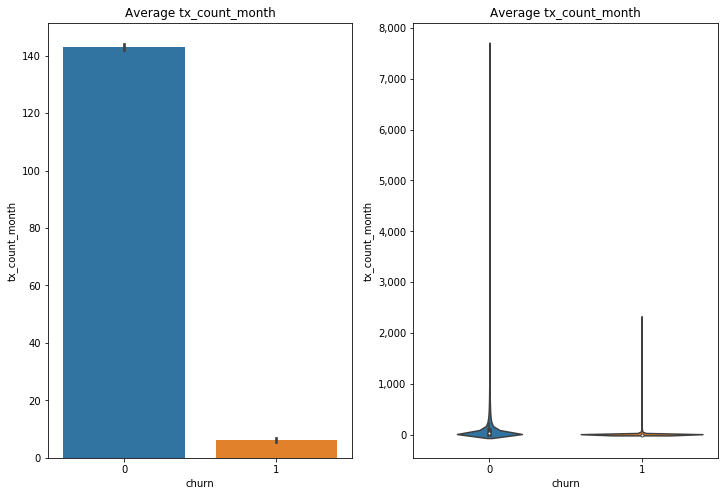

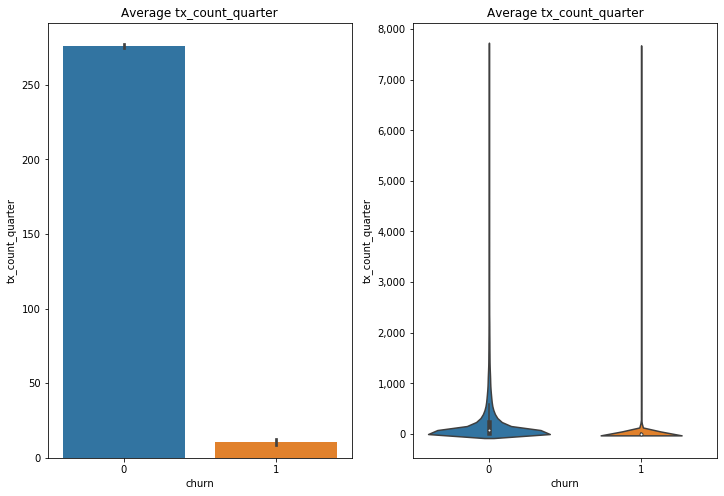

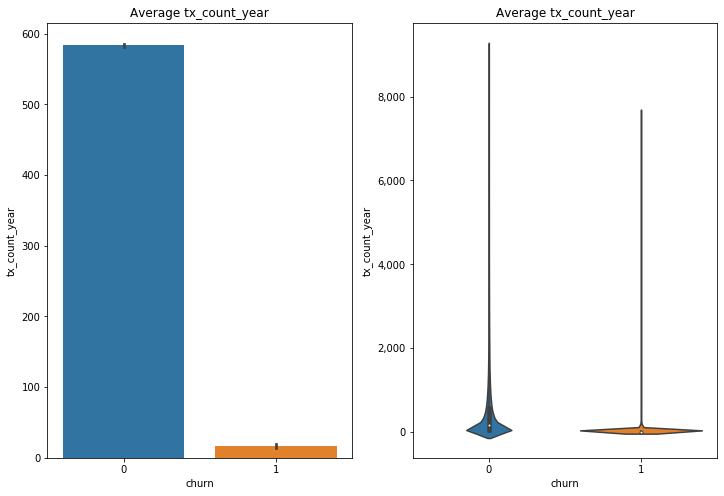

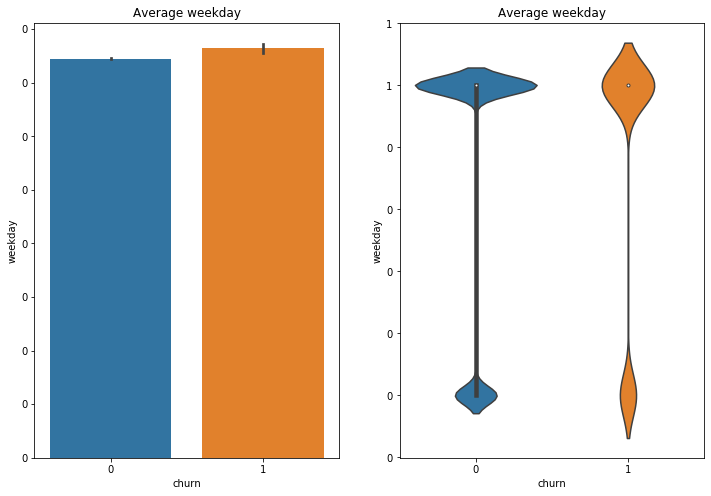

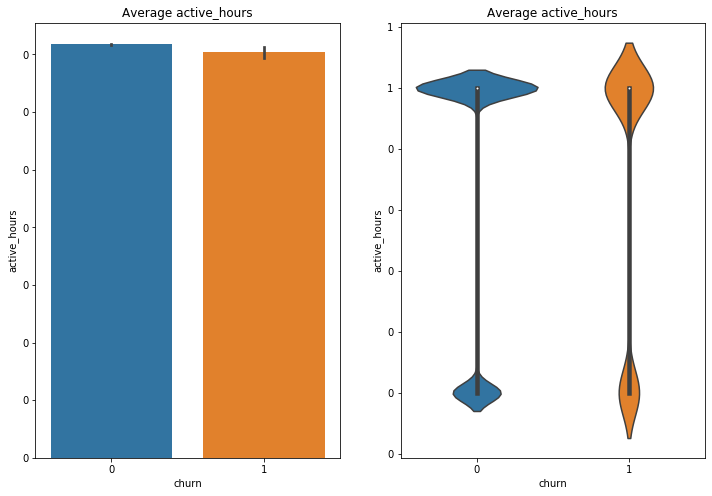

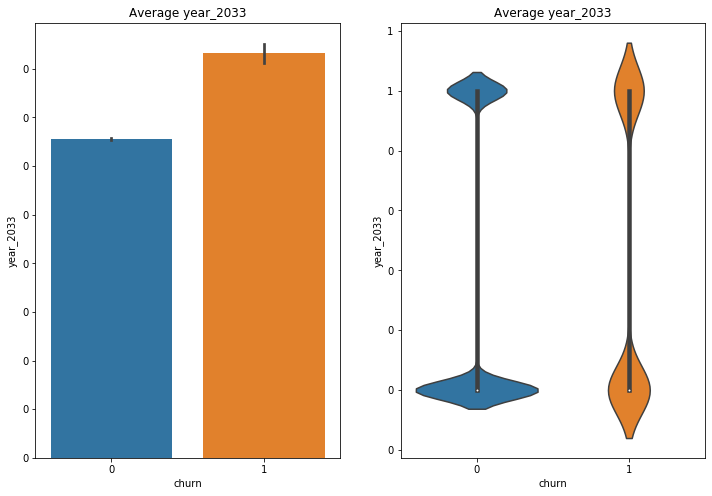

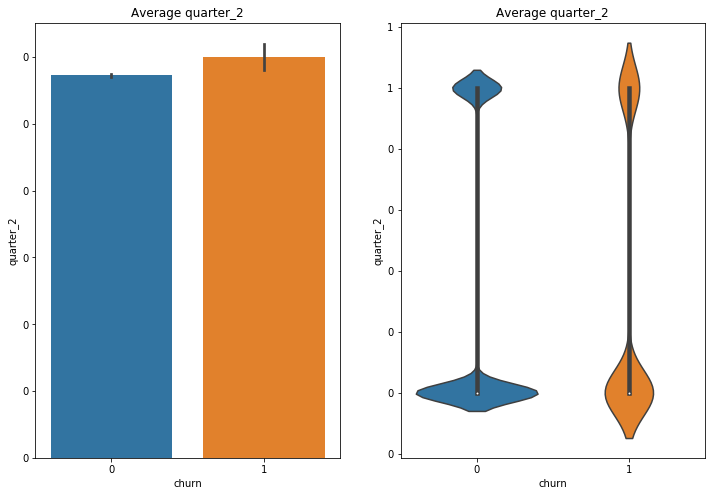

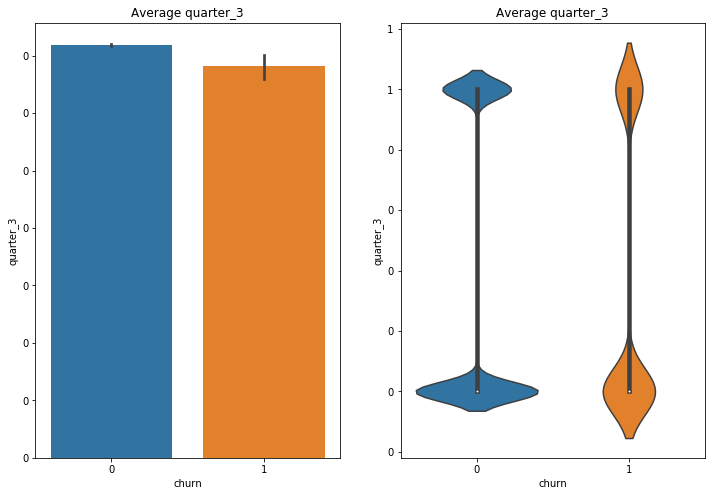

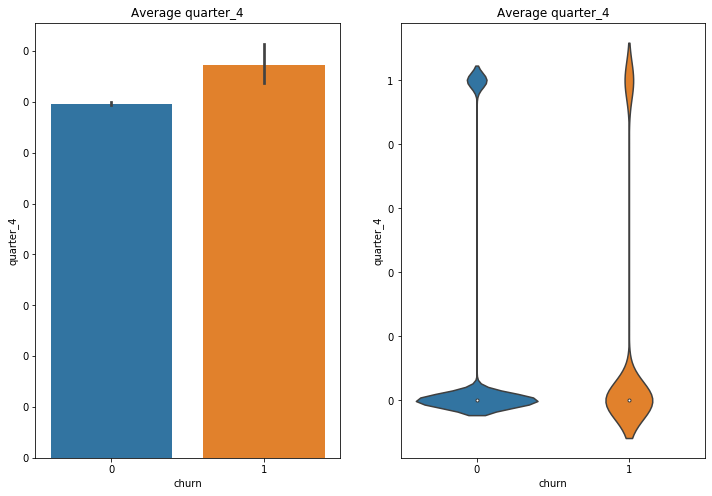

In [92]:
for feature in feature_list:
    churn_plots(feature)

### You can see from the visualizations that 'amount_usd' and 'td_last_purchase' and 'tx_count' features are showing huge differences between the churn and no churn groups.

### The weekday, active_hours, year and quarter features don't appear to have large differences in the average churn groups, but the distributions do appear to be wider so maybe it is worth keeping them in the model.

### Inital Feature selection

In [110]:
X = df_nolastq[['amount_usd', 'td_last_purchase', 'tx_count_day', 'tx_count_month','tx_count_quarter', 
                'weekday','active_hours', 'year_2033', 'quarter_2', 'quarter_3', 'quarter_4']]

In [113]:
y = df_nolastq['churn_transform']

### Correlation of Features and PCA

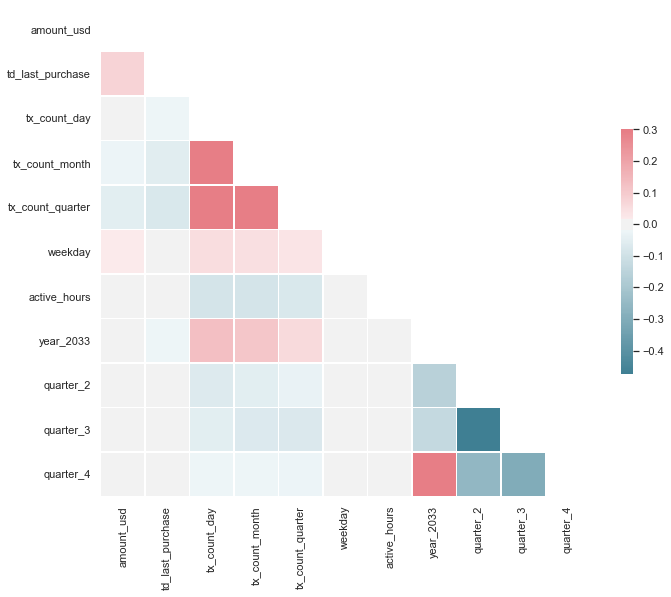

In [112]:
#look at the correlation of features
#build a correlation matrix 
from string import ascii_letters

sns.set(style='white')

#compute the correlation matrix
corr = X.corr()

#generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

#set up the matplotlib figure
f, ax = plt.subplots(figsize=(11,9))

#generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
           square=True, linewidth=.5, cbar_kws={"shrink": .5})

unsurprisingly, the tx_count features are highly correlated. 

In [118]:
#PCA analysis
from sklearn.decomposition import PCA
pca_1 = PCA(n_components=3)
pca_2 = PCA(n_components=4)
pca_3 = PCA(n_components=5)

principalComponents_1 = pca_1.fit_transform(X)
principalComponents_2 = pca_2.fit_transform(X)
principalComponents_3 = pca_3.fit_transform(X)

print(np.sum(pca_1.explained_variance_ratio_))
print(np.sum(pca_2.explained_variance_ratio_))
print(np.sum(pca_3.explained_variance_ratio_))

0.9285915227779004
0.989344673109413
0.9999989984918451


only 3 features explains more than 92% of the variance in the data.

### Train Test Split

In [114]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

### Modeling - Random Forest ensemble method (multiple decision tree models)

In [119]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report, log_loss

In [120]:
#try initial Random forest model using a pipeline
pipe_rf = Pipeline([('scaler', StandardScaler()),
                    ('pca', PCA(n_components=5, random_state=123)),
                    ('clf', RandomForestClassifier(random_state=123))])

#fit the model
pipe_rf.fit(X_train, y_train)

#make predictions
training_preds = pipe_rf.predict(X_train)
test_preds = pipe_rf.predict(X_test)

#classification report
training_classification = classification_report(y_train, training_preds)
test_classification = classification_report(y_test, test_preds)

#accuracy
print('Accuracy %:', pipe_rf.score(X_test, y_test))

#Classification report 
print('\nTraining Classification Report:\n', training_classification)
print('\nTesting Classification Report:\n', test_classification)

Accuracy %: 0.9790548922115645

Training Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    575112
           1       1.00      1.00      1.00     12567

    accuracy                           1.00    587679
   macro avg       1.00      1.00      1.00    587679
weighted avg       1.00      1.00      1.00    587679


Testing Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    191781
           1       0.50      0.16      0.25      4112

    accuracy                           0.98    195893
   macro avg       0.74      0.58      0.62    195893
weighted avg       0.97      0.98      0.97    195893



accuracy = (true pos + true neg) / total

precision = true positives / (true pos+false pos)

recall = true pos / (true pos + false neg)

f1 = precision*recall / precision+recall

### Accuracy is suspiciously high, most likely because the churn group is so small the model can just guess everything is no churn and come out with very high accuracy. This is an imbalanced sample issue.

### The precision difference between the training and testing group also indicates severe overfitting.

### The precision, recall, and f1-score of the testing group are very low when predicting who churned. This definitely needs to be improved.

## Hyperparameter tuning to improve model

In [ ]:
# Set grid search params
param_grid_forest = [ 
  {'clf__n_estimators': [10, 100],
   'clf__criterion': ['entropy', 'gini'], 
   'clf__max_depth': [None, 6],  
   'clf__min_samples_leaf':[1, 2],  
   'clf__min_samples_split':[2, 3]
  }
]

# Construct grid search
gs_rf = GridSearchCV(estimator=pipe_rf,
            param_grid=param_grid_forest,
            scoring='accuracy',
            cv=3, verbose=2, return_train_score = True)

# Fit using grid search
gs_rf.fit(X_train, y_train)

#make predictions
training_preds = gs_rf.predict(X_train)
test_preds = gs_rf.predict(X_test)

#classification report
training_classification = classification_report(y_train, training_preds)
test_classification = classification_report(y_test, test_preds)

# Best accuracy
print('Best accuracy: %.3f' % gs_rf.best_score_)

# Best params
print('\nBest params:\n', gs_rf.best_params_)

#Classification report 
print('\nTraining Classification Report:\n', training_classification)
print('\nTesting Classification Report:\n', test_classification)

In [ ]:
#above gridsearch took over an hour to run - best parameters are below:
#Best params:
#{'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}

In [123]:
#try new Random Forest with new parameters from gridsearch
pipe_rf = Pipeline([('scaler', StandardScaler()),
                    ('pca', PCA(n_components=5, random_state=123)),
                    ('clf', RandomForestClassifier(criterion='entropy',
                                                   n_estimators=100,
                                                   max_depth=None,
                                                   min_samples_leaf=2,
                                                   min_samples_split=2,
                                                   random_state=123))])

#fit the model
pipe_rf.fit(X_train, y_train)

#make predictions
training_preds = pipe_rf.predict(X_train)
test_preds = pipe_rf.predict(X_test)

#classification report
training_classification = classification_report(y_train, training_preds)
test_classification = classification_report(y_test, test_preds)

#accuracy
print('Accuracy %:', pipe_rf.score(X_test, y_test))

#Classification report 
print('\nTraining Classification Report:\n', training_classification)
print('\nTesting Classification Report:\n', test_classification)

Accuracy %: 0.9800248094623085

Training Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    575112
           1       0.99      0.51      0.68     12567

    accuracy                           0.99    587679
   macro avg       0.99      0.76      0.84    587679
weighted avg       0.99      0.99      0.99    587679


Testing Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    191781
           1       0.59      0.15      0.24      4112

    accuracy                           0.98    195893
   macro avg       0.79      0.58      0.62    195893
weighted avg       0.97      0.98      0.97    195893



### The churn group in the testing set is still performing very poorly. The precision is only 59% and the recall is only 15% which indicates the model is still overfitting. Need to balance data better.

## Feature Importance:

Feature ranking:
1. feature 2 (0.218183)
2. feature 1 (0.211232)
3. feature 3 (0.200870)
4. feature 0 (0.200324)
5. feature 4 (0.169391)


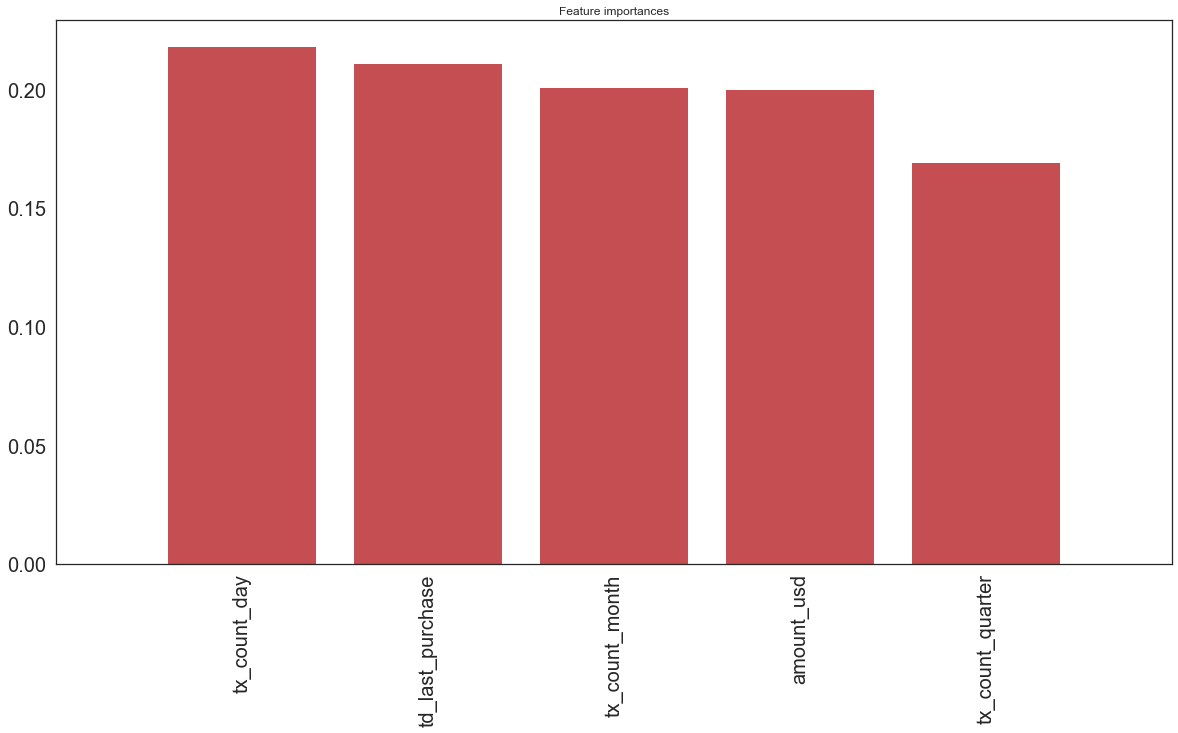

In [152]:
importances = pipe_rf[2].feature_importances_

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(5):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(range(5), importances[indices],
       color="r", align="center")
plt.xticks(range(5), X.columns[indices], rotation='vertical')
plt.xlim([-1, 5])
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
plt.show()

## Check Confusion Matrix

In [149]:
#look at an sklearn confusion matrix 
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix 
from sklearn.utils.multiclass import unique_labels

matrix = confusion_matrix(y_test, test_preds)
matrix

array([[191352,    429],
       [  3484,    628]], dtype=int64)

Confusion matrix, without normalization
[[191352    429]
 [  3484    628]]
Normalized confusion matrix
[[1.  0. ]
 [0.8 0.2]]


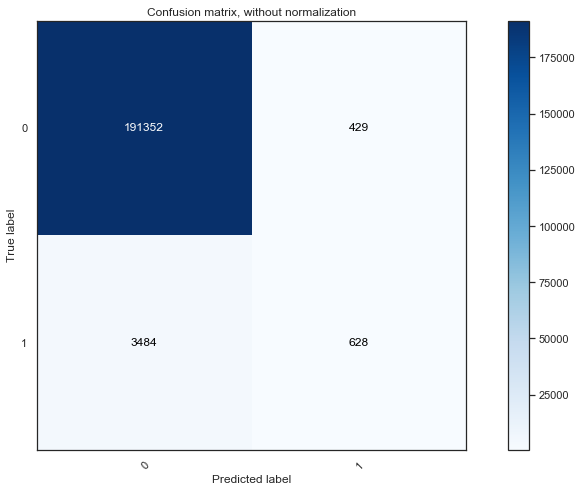

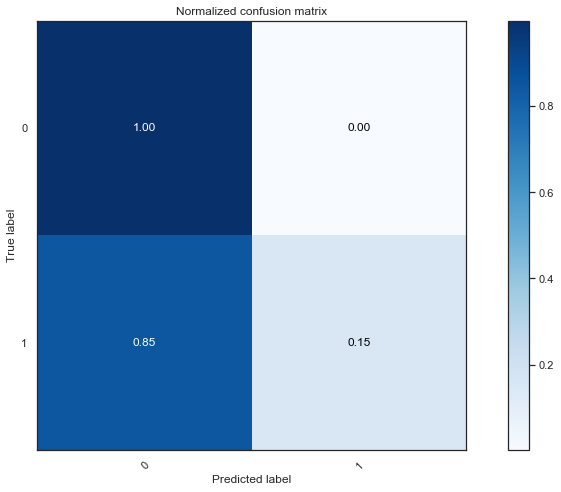

In [150]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(12, 7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=1)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, test_preds, classes=np.arange(0, 2, 1, dtype=int),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, test_preds, classes=np.arange(0, 2, 1, dtype=int), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Conclusion of results:

### Features are good predictors for churn based on EDA.

### The model is severely overfitting due to unbalanced churn vs no-churn groups. If given more time I would use techniques such as "over-sampling" or "under-sampling" to balance out the churn groups and build a more useful model. 

### Gridsearch helped the precision of the churn group from 50% to 59% but the recall and f1-score didn't improve. 

### I would also try an XG Boost model to see if that improved results at all.